<a href="https://colab.research.google.com/github/hibaessid/SymfonyProject/blob/master/Vgg1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Concatenate
from keras.optimizers import Adam

# Load dataset
mass_train = pd.read_csv("/content/drive/MyDrive/NvData/breast_cancer_data/csv/mass_case_description_train_set.csv")
mass_test = pd.read_csv("/content/drive/MyDrive/NvData/breast_cancer_data/csv/mass_case_description_test_set.csv")
df_meta = pd.read_csv('/content/drive/MyDrive/NvData/breast_cancer_data/csv/meta.csv')
df_meta.head()

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2


In [ ]:
# Read the CSV file
df_dicom  = pd.read_csv('/content/drive/MyDrive/NvData/breast_cancer_data/csv/dicom_info.csv')

image_dir = '/content/drive/MyDrive/NvData/breast_cancer_data/jpeg'
# set correct image path for image types
imdir = '/content/drive/MyDrive/NvData/breast_cancer_data/jpeg'
cropped_images = df_dicom[df_dicom.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [ ]:
full_mammogram_images = df_dicom[df_dicom.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [ ]:
# change directory path of images
cropped_images = cropped_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)
full_mammogram_images = full_mammogram_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)
#ROI_mask_images = ROI_mask_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)

# view new paths
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammogram_images.iloc[0])
#print('ROI Mask Images paths:\n')
#print(ROI_mask_images.iloc[0])

Cropped Images paths:

/content/drive/MyDrive/NvData/breast_cancer_data/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

/content/drive/MyDrive/NvData/breast_cancer_data/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


In [ ]:
 #organize image paths
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammogram_images:
    key = dicom.split("/")[6]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[6]
    cropped_images_dict[key] = dicom
#for dicom in ROI_mask_images:
    #key = dicom.split("/")[6]
    #ROI_mask_images[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('jpeg',
 '/content/drive/MyDrive/NvData/breast_cancer_data/jpeg/1.3.6.1.4.1.9590.100.1.2.247594800112988856209160032211145354590/1-047.jpg')

In [ ]:
 #organize image paths
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammogram_images:
    key = dicom.split("/")[6]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[6]
    cropped_images_dict[key] = dicom
#for dicom in ROI_mask_images:
    #key = dicom.split("/")[6]
    #ROI_mask_images[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('jpeg',
 '/content/drive/MyDrive/NvData/breast_cancer_data/jpeg/1.3.6.1.4.1.9590.100.1.2.247594800112988856209160032211145354590/1-047.jpg')

In [ ]:
# rename columns
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train.head(5)


,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [ ]:
# Preprocess training data

#filling missing values
mass_train['mass_shape'] = mass_train['mass_shape'].fillna(method='bfill')
mass_train['mass_margins'] = mass_train['mass_margins'].fillna(method='bfill')

from sklearn.preprocessing import LabelEncoder



label_encoder = LabelEncoder()
mass_train['left_or_right_breast'] = label_encoder.fit_transform(mass_train['left_or_right_breast'])
mass_train['image_view'] = label_encoder.fit_transform(mass_train['image_view'])

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()#normalisation
mass_train[['breast_density', 'assessment', 'subtlety','abnormality_id']] = scaler.fit_transform(mass_train[['breast_density', 'assessment', 'subtlety','abnormality_id']])


In [ ]:
#test preprocessing
from sklearn.preprocessing import LabelEncoder



label_encoder = LabelEncoder()
mass_test['left_or_right_breast'] = label_encoder.fit_transform(mass_test['left_or_right_breast'])
mass_test['image_view'] = label_encoder.fit_transform(mass_test['image_view'])

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
mass_test[['breast_density', 'assessment', 'subtlety','abnormality_id']] = scaler.fit_transform(mass_test[['breast_density', 'assessment', 'subtlety','abnormality_id']])

In [ ]:
mass_test.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,1.000000,0,0,0.0,mass,IRREGULAR,SPICULATED,1.0,MALIGNANT,1.00,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,1.000000,0,1,0.0,mass,IRREGULAR,SPICULATED,1.0,MALIGNANT,1.00,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,0.333333,0,0,0.0,mass,ROUND,CIRCUMSCRIBED,0.8,MALIGNANT,0.75,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,0.333333,0,1,0.0,mass,ROUND,ILL_DEFINED,0.8,MALIGNANT,0.75,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,0.666667,1,0,0.0,mass,ROUND,OBSCURED,0.0,BENIGN,0.25,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [ ]:
print("Unique values in mass_shape column:")
print(mass_train['mass_shape'].unique())

print("\nUnique values in mass_margins column:")
print(mass_train['mass_margins'].unique())

print("\nNull values in mass_shape column:")
print(mass_train['mass_shape'].isnull().sum())

print("\nNull values in mass_margins column:")
print(mass_train['mass_margins'].isnull().sum())


Unique values in mass_shape column:
['IRREGULAR-ARCHITECTURAL_DISTORTION' 'ARCHITECTURAL_DISTORTION' 'OVAL'
 'IRREGULAR' 'LYMPH_NODE' 'LOBULATED-LYMPH_NODE' 'LOBULATED'
 'FOCAL_ASYMMETRIC_DENSITY' 'ROUND' 'LOBULATED-ARCHITECTURAL_DISTORTION'
 'ASYMMETRIC_BREAST_TISSUE' 'LOBULATED-IRREGULAR' 'OVAL-LYMPH_NODE'
 'LOBULATED-OVAL' 'ROUND-OVAL' 'IRREGULAR-FOCAL_ASYMMETRIC_DENSITY'
 'ROUND-IRREGULAR-ARCHITECTURAL_DISTORTION' 'ROUND-LOBULATED']

Unique values in mass_margins column:
['SPICULATED' 'ILL_DEFINED' 'CIRCUMSCRIBED' 'ILL_DEFINED-SPICULATED'
 'OBSCURED' 'OBSCURED-ILL_DEFINED' 'MICROLOBULATED'
 'MICROLOBULATED-ILL_DEFINED-SPICULATED' 'MICROLOBULATED-SPICULATED'
 'CIRCUMSCRIBED-ILL_DEFINED' 'MICROLOBULATED-ILL_DEFINED'
 'CIRCUMSCRIBED-OBSCURED' 'OBSCURED-SPICULATED'
 'OBSCURED-ILL_DEFINED-SPICULATED' 'CIRCUMSCRIBED-MICROLOBULATED']

Null values in mass_shape column:
0

Null values in mass_margins column:
0


In [ ]:
#oneHot encoding
from sklearn.preprocessing import OneHotEncoder

# Create OneHotEncoder instances
encoder_shape = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder_margins = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform mass_shape and mass_margins columns
mass_shape_encoded = encoder_shape.fit_transform(mass_train[['mass_shape']])
mass_margins_encoded = encoder_margins.fit_transform(mass_train[['mass_margins']])

# Check the shapes of the transformed arrays
print("Shape of mass_shape_encoded:", mass_shape_encoded.shape)
print("Shape of mass_margins_encoded:", mass_margins_encoded.shape)


Shape of mass_shape_encoded: (1318, 18)
Shape of mass_margins_encoded: (1318, 15)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Create OneHotEncoder instances
encoder_shape = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder_margins = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit encoders on mass_train data
encoder_shape.fit(mass_train[['mass_shape']])
encoder_margins.fit(mass_train[['mass_margins']])

# Transform mass_test data using the fitted encoders
mass_shape_encoded_test = encoder_shape.transform(mass_test[['mass_shape']])
mass_margins_encoded_test = encoder_margins.transform(mass_test[['mass_margins']])

# Get the feature names from the categories_ attribute of the encoder objects
shape_feature_names = encoder_shape.get_feature_names_out(['mass_shape'])
margins_feature_names = encoder_margins.get_feature_names_out(['mass_margins'])

# Convert mass_shape_encoded_test and mass_margins_encoded_test to DataFrames
mass_shape_df_test = pd.DataFrame(mass_shape_encoded_test, columns=shape_feature_names)
mass_margins_df_test = pd.DataFrame(mass_margins_encoded_test, columns=margins_feature_names)

# Concatenate mass_test with mass_shape_df_test and mass_margins_df_test horizontally
mass_test_combined = pd.concat([mass_test, mass_shape_df_test, mass_margins_df_test], axis=1)

# Optionally, drop the original mass_shape and mass_margins columns from mass_test_combined
mass_test_combined.drop(columns=['mass_shape', 'mass_margins'], inplace=True)

# Display the preprocessed mass_test_combined data
mass_test_combined.head()
mass_test_combined.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 45 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   patient_id                                           378 non-null    object 
 1   breast_density                                       378 non-null    float64
 2   left_or_right_breast                                 378 non-null    int64  
 3   image_view                                           378 non-null    int64  
 4   abnormality_id                                       378 non-null    float64
 5   abnormality_type                                     378 non-null    object 
 6   assessment                                           378 non-null    float64
 7   pathology                                            378 non-null    object 
 8   subtlety                                             378 non-null    f

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Get the feature names from the categories_ attribute of the encoder objects
shape_feature_names = encoder_shape.get_feature_names_out(['mass_shape'])
margins_feature_names = encoder_margins.get_feature_names_out(['mass_margins'])

# Convert mass_shape_encoded and mass_margins_encoded to DataFrames
mass_shape_df = pd.DataFrame(mass_shape_encoded, columns=shape_feature_names)
mass_margins_df = pd.DataFrame(mass_margins_encoded, columns=margins_feature_names)

# Concatenate mass_train with mass_shape_df and mass_margins_df horizontally
mass_train_combined = pd.concat([mass_train, mass_shape_df, mass_margins_df], axis=1)

# Optionally, drop the original mass_shape and mass_margins columns from mass_train_combined
mass_train_combined.drop(columns=['mass_shape', 'mass_margins','abnormality_type'], inplace=True)


mass_train_combined.head()
mass_train_combined.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 44 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   patient_id                                           1318 non-null   object 
 1   breast_density                                       1318 non-null   float64
 2   left_or_right_breast                                 1318 non-null   int64  
 3   image_view                                           1318 non-null   int64  
 4   abnormality_id                                       1318 non-null   float64
 5   assessment                                           1318 non-null   float64
 6   pathology                                            1318 non-null   object 
 7   subtlety                                             1318 non-null   float64
 8   image_file_path                                      1318 non-null  

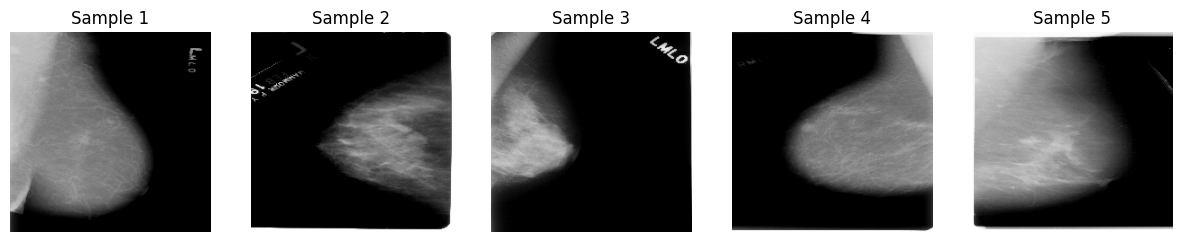

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the processed image data
X_cropped_test_processed = np.load('/content/drive/MyDrive/NvData/processed_images/X_full_mammographic_test_processed.npy')

# Display some sample images
num_samples = 5  # Number of samples to display
sample_indices = np.random.choice(len(X_cropped_test_processed), num_samples, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_cropped_test_processed[idx])
    plt.axis('off')
    plt.title(f"Sample {i+1}")

plt.show()


In [ ]:
import numpy as np

# Load the processed image data
X_full_mammographic_train_processed = np.load('/content/drive/MyDrive/NvData/processed_images/X_full_mammographic_train_processed.npy')
X_full_mammographic_test_processed = np.load('/content/drive/MyDrive/NvData/processed_images/X_full_mammographic_test_processed.npy')
X_cropped_train_processed = np.load('/content/drive/MyDrive/NvData/processed_images/X_cropped_train_processed.npy')
X_cropped_test_processed = np.load('/content/drive/MyDrive/NvData/processed_images/X_cropped_test_processed.npy')

In [ ]:
from keras.applications.vgg16 import preprocess_input

# Preprocess input images
X_full_mammographic_train_processed = preprocess_input(X_full_mammographic_train_processed)
X_full_mammographic_test_processed = preprocess_input(X_full_mammographic_test_processed)
X_cropped_train_processed = preprocess_input(X_cropped_train_processed)
X_cropped_test_processed = preprocess_input(X_cropped_test_processed)


In [ ]:
# Ensure the shapes are correct
print("Shape of X_full_mammographic_test_processed:", X_full_mammographic_test_processed.shape)
print("Shape of X_cropped_test_processed:", X_cropped_test_processed.shape)
print("Shape of X_cropped_train_processed:", X_cropped_train_processed.shape)
print("Shape of X_full_mammographic_train_processed:", X_full_mammographic_train_processed.shape)


Shape of X_full_mammographic_test_processed: (378, 224, 224, 3)
Shape of X_cropped_test_processed: (378, 224, 224, 3)
Shape of X_cropped_train_processed: (1318, 224, 224, 3)
Shape of X_full_mammographic_train_processed: (1318, 224, 224, 3)


In [ ]:
# Get metadata
X_metadata_train = mass_train_combined[['breast_density', 'left_or_right_breast', 'image_view', 'abnormality_id', 'assessment', 'subtlety',
                                         'mass_shape_ARCHITECTURAL_DISTORTION', 'mass_shape_ASYMMETRIC_BREAST_TISSUE', 'mass_shape_FOCAL_ASYMMETRIC_DENSITY',
                                         'mass_shape_IRREGULAR', 'mass_shape_IRREGULAR-ARCHITECTURAL_DISTORTION', 'mass_shape_IRREGULAR-FOCAL_ASYMMETRIC_DENSITY',
                                         'mass_shape_LOBULATED', 'mass_shape_LOBULATED-ARCHITECTURAL_DISTORTION', 'mass_shape_LOBULATED-IRREGULAR',
                                         'mass_shape_LOBULATED-LYMPH_NODE', 'mass_shape_LOBULATED-OVAL', 'mass_shape_LYMPH_NODE', 'mass_shape_OVAL',
                                         'mass_shape_OVAL-LYMPH_NODE', 'mass_shape_ROUND', 'mass_shape_ROUND-IRREGULAR-ARCHITECTURAL_DISTORTION',
                                         'mass_shape_ROUND-LOBULATED', 'mass_shape_ROUND-OVAL', 'mass_margins_CIRCUMSCRIBED', 'mass_margins_CIRCUMSCRIBED-ILL_DEFINED',
                                         'mass_margins_CIRCUMSCRIBED-MICROLOBULATED', 'mass_margins_CIRCUMSCRIBED-OBSCURED', 'mass_margins_ILL_DEFINED',
                                         'mass_margins_ILL_DEFINED-SPICULATED', 'mass_margins_MICROLOBULATED', 'mass_margins_MICROLOBULATED-ILL_DEFINED',
                                         'mass_margins_MICROLOBULATED-ILL_DEFINED-SPICULATED', 'mass_margins_MICROLOBULATED-SPICULATED', 'mass_margins_OBSCURED',
                                         'mass_margins_OBSCURED-ILL_DEFINED', 'mass_margins_OBSCURED-ILL_DEFINED-SPICULATED', 'mass_margins_OBSCURED-SPICULATED',
                                         'mass_margins_SPICULATED']].values

X_metadata_test = mass_test_combined[['breast_density', 'left_or_right_breast', 'image_view', 'abnormality_id', 'assessment', 'subtlety',
                                       'mass_shape_ARCHITECTURAL_DISTORTION', 'mass_shape_ASYMMETRIC_BREAST_TISSUE', 'mass_shape_FOCAL_ASYMMETRIC_DENSITY',
                                       'mass_shape_IRREGULAR', 'mass_shape_IRREGULAR-ARCHITECTURAL_DISTORTION', 'mass_shape_IRREGULAR-FOCAL_ASYMMETRIC_DENSITY',
                                       'mass_shape_LOBULATED', 'mass_shape_LOBULATED-ARCHITECTURAL_DISTORTION', 'mass_shape_LOBULATED-IRREGULAR',
                                       'mass_shape_LOBULATED-LYMPH_NODE', 'mass_shape_LOBULATED-OVAL', 'mass_shape_LYMPH_NODE', 'mass_shape_OVAL',
                                       'mass_shape_OVAL-LYMPH_NODE', 'mass_shape_ROUND', 'mass_shape_ROUND-IRREGULAR-ARCHITECTURAL_DISTORTION',
                                       'mass_shape_ROUND-LOBULATED', 'mass_shape_ROUND-OVAL', 'mass_margins_CIRCUMSCRIBED', 'mass_margins_CIRCUMSCRIBED-ILL_DEFINED',
                                       'mass_margins_CIRCUMSCRIBED-MICROLOBULATED', 'mass_margins_CIRCUMSCRIBED-OBSCURED', 'mass_margins_ILL_DEFINED',
                                       'mass_margins_ILL_DEFINED-SPICULATED', 'mass_margins_MICROLOBULATED', 'mass_margins_MICROLOBULATED-ILL_DEFINED',
                                       'mass_margins_MICROLOBULATED-ILL_DEFINED-SPICULATED', 'mass_margins_MICROLOBULATED-SPICULATED', 'mass_margins_OBSCURED',
                                       'mass_margins_OBSCURED-ILL_DEFINED', 'mass_margins_OBSCURED-ILL_DEFINED-SPICULATED', 'mass_margins_OBSCURED-SPICULATED',
                                       'mass_margins_SPICULATED']].values



In [ ]:
print(X_metadata_test.shape)
print(X_metadata_train.shape)



(378, 39)
(1318, 39)


In [ ]:
print("Shape of X_metadata_train:", X_metadata_train.shape)
print("Shape of X_metadata_test:", X_metadata_test.shape)

Shape of X_metadata_train: (1318, 39)
Shape of X_metadata_test: (378, 39)


In [ ]:
mass_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   patient_id               1318 non-null   object 
 1   breast_density           1318 non-null   float64
 2   left_or_right_breast     1318 non-null   int64  
 3   image_view               1318 non-null   int64  
 4   abnormality_id           1318 non-null   float64
 5   abnormality_type         1318 non-null   object 
 6   mass_shape               1318 non-null   object 
 7   mass_margins             1318 non-null   object 
 8   assessment               1318 non-null   float64
 9   pathology                1318 non-null   object 
 10  subtlety                 1318 non-null   float64
 11  image_file_path          1318 non-null   object 
 12  cropped_image_file_path  1318 non-null   object 
 13  ROI_mask_file_path       1318 non-null   object 
dtypes: float64(4), int64(2),

In [ ]:
print("Shape of X_full_mammographic_train:", X_full_mammographic_train_processed.shape)
print("Shape of X_cropped_test:", X_cropped_test_processed.shape)
print("Shape of X_full_mammographic_test:", X_full_mammographic_test_processed.shape)
print("Shape of X_cropped_train:", X_cropped_train_processed.shape)
print("Shape of X_metadata_train:", X_metadata_train.shape)
print("Shape of X_metadata_test:", X_metadata_test.shape)

Shape of X_full_mammographic_train: (1318, 224, 224, 3)
Shape of X_cropped_test: (378, 224, 224, 3)
Shape of X_full_mammographic_test: (378, 224, 224, 3)
Shape of X_cropped_train: (1318, 224, 224, 3)
Shape of X_metadata_train: (1318, 39)
Shape of X_metadata_test: (378, 39)


In [ ]:

# Combine the processed image data with metadata
X_train_combined = [X_full_mammographic_train_processed, X_cropped_train_processed, X_metadata_train]
X_test_combined = [X_full_mammographic_test_processed, X_cropped_test_processed, X_metadata_test]

# Check the shapes to ensure they match
print("Shape of X_train_combined[0]:", X_train_combined[0].shape)
print("Shape of X_train_combined[1]:", X_train_combined[1].shape)
print("Shape of X_train_combined[2]:", X_train_combined[2].shape)

Shape of X_train_combined[0]: (1318, 224, 224, 3)
Shape of X_train_combined[1]: (1318, 224, 224, 3)
Shape of X_train_combined[2]: (1318, 39)


In [ ]:
from keras.applications import VGG16
from keras.layers import Input, Flatten, Dense, Concatenate
from keras.models import Model
from keras.optimizers import Adam

# Define class_mapper
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

# Define y_train and y_test
y_train = mass_train['pathology'].replace(class_mapper).values
y_test = mass_test['pathology'].replace(class_mapper).values

# Define input layers
input_full_mammographic = Input(shape=(224, 224, 3), name='input_full_mammographic')
input_cropped = Input(shape=(224, 224, 3), name='input_cropped')
input_metadata = Input(shape=(39,), name='input_metadata')

# Define VGG16 model for images
def create_vgg_model(input_tensor, name_prefix):
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
    for layer in base_model.layers:
        layer._name = f"{name_prefix}_{layer.name}"  # Modify layer names to include the input name
        layer.trainable = True
    return base_model.output

# Build VGG16 models with unique names
vgg_full_mammographic = create_vgg_model(input_full_mammographic, name_prefix='vgg_full_mammographic')
vgg_cropped = create_vgg_model(input_cropped, name_prefix='vgg_cropped')

# Flatten outputs from VGG16 models
output_full_mammographic_flat = Flatten()(vgg_full_mammographic)
output_cropped_flat = Flatten()(vgg_cropped)

# Add Dense layer for metadata
output_metadata = Dense(10, activation='relu', name='output_metadata')(input_metadata) # Added layer

# Concatenate outputs from VGG16 models with metadata input
combined_output = Concatenate()([output_full_mammographic_flat, output_cropped_flat, output_metadata])

# Add Dense layers for classification
x = Dense(128, activation='relu')(combined_output)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[input_full_mammographic, input_cropped, input_metadata], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
history = model.fit(X_train_combined, y_train, validation_split=0.2, epochs=3, batch_size=16)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 vgg_full_mammographic_inpu  [(None, 224, 224, 3)]        0         []                            
 t_full_mammographic (Input                                                                       
 Layer)                                                                                           
                                                                                                  
 vgg_cropped_input_cropped   [(None, 224, 224, 3)]        0         []                            
 (InputLayer)                                                                                     
                                                                                                  
 vgg_full_mammographic_bloc  (None, 224, 224, 64)         1792      ['vgg_full_mammographic_in

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test_combined, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

12/12 [==============================] - 27s 1s/step - loss: 0.7428 - accuracy: 0.3889
Test Loss: 0.7427761554718018
Test Accuracy: 0.3888888955116272


In [ ]:
from sklearn.metrics import classification_report

# Predict classes for test data
y_pred = model.predict(X_test_combined)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Generate classification report
print(classification_report(y_test, y_pred_classes, target_names=['BENIGN', 'MALIGNANT']))


12/12 [==============================] - 3s 234ms/step
              precision    recall  f1-score   support

      BENIGN       0.00      0.00      0.00       231
   MALIGNANT       0.39      1.00      0.56       147

    accuracy                           0.39       378
   macro avg       0.19      0.50      0.28       378
weighted avg       0.15      0.39      0.22       378



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


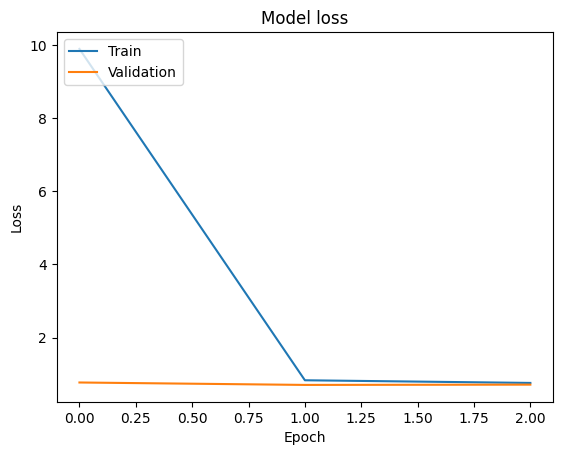

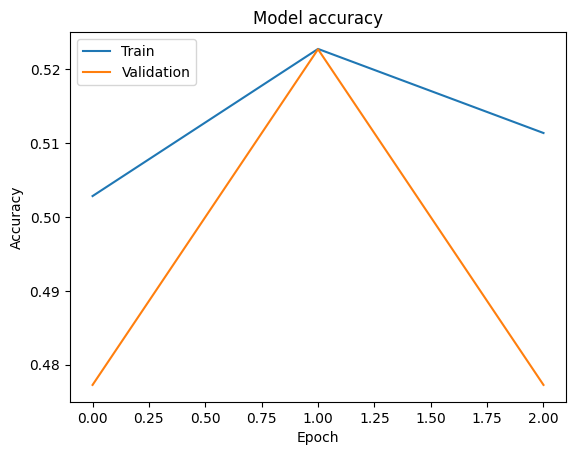

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
